In [1]:
# Import packages
import os
import sys
import warnings
import pandas as pd
import numpy as np
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import seaborn as sns

# Set environment
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Remove warnings
warnings.filterwarnings("ignore")


# Set figure size
plt.rcParams["figure.figsize"] = (10,7)

# Spark Session builder
from pyspark.sql import SparkSession
spark = SparkSession.builder.config("spark.debug.maxToStringFields", "100").getOrCreate()

In [2]:
df = spark.read.csv("heart.csv", header = True, inferSchema = True)
cols = df.columns
df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- ChestPainType: string (nullable = true)
 |-- RestingBP: integer (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- FastingBS: integer (nullable = true)
 |-- RestingECG: string (nullable = true)
 |-- MaxHR: integer (nullable = true)
 |-- ExerciseAngina: string (nullable = true)
 |-- Oldpeak: double (nullable = true)
 |-- ST_Slope: string (nullable = true)
 |-- HeartDisease: integer (nullable = true)



In [3]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'HeartDisease', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['Age', 'RestingBP', 'Cholesterol',
               'FastingBS', 'MaxHR', 'Oldpeak']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [4]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- ChestPainType: string (nullable = true)
 |-- RestingBP: integer (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- FastingBS: integer (nullable = true)
 |-- RestingECG: string (nullable = true)
 |-- MaxHR: integer (nullable = true)
 |-- ExerciseAngina: string (nullable = true)
 |-- Oldpeak: double (nullable = true)
 |-- ST_Slope: string (nullable = true)
 |-- HeartDisease: integer (nullable = true)



In [5]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,1.0,0.0,1.0,0.0,1.0
features,"[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...","(1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...","(0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ..."
Age,40,49,37,48,54
Sex,M,F,M,F,M
ChestPainType,ATA,NAP,ATA,ASY,NAP
RestingBP,140,160,130,138,150
Cholesterol,289,180,283,214,195
FastingBS,0,0,0,0,0
RestingECG,Normal,Normal,ST,Normal,Normal
MaxHR,172,156,98,108,122


In [6]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 654
Test Dataset Count: 264


In [7]:
#Logistic Regression Model

from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

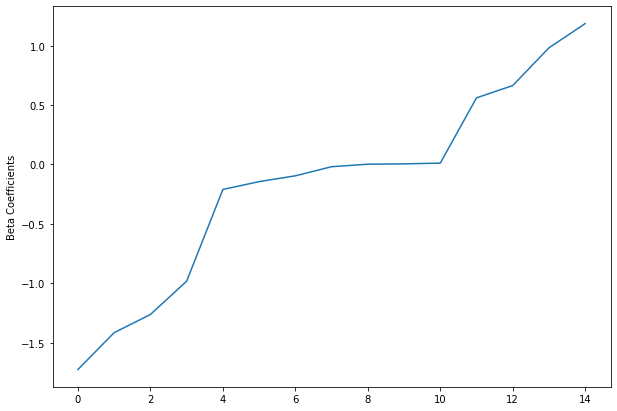

In [8]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

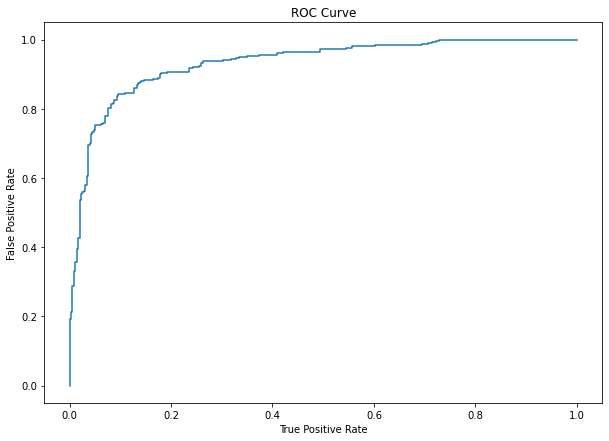

Training set areaUnderROC: 0.9316478342749516


In [9]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [10]:
#Make predictions on the test set.
predictions = lrModel.transform(test)
predictions.select('Age', 'ChestPainType', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-------------+-----+--------------------+----------+--------------------+
|Age|ChestPainType|label|       rawPrediction|prediction|         probability|
+---+-------------+-----+--------------------+----------+--------------------+
| 51|          ASY|  0.0|[2.95850178541345...|       0.0|[0.95066377183505...|
| 49|          ASY|  0.0|[3.09458202619106...|       0.0|[0.95666870490322...|
| 57|          ASY|  0.0|[4.87300039217166...|       0.0|[0.99240770721233...|
| 42|          ASY|  0.0|[3.31268040049391...|       0.0|[0.96486127041036...|
| 65|          ASY|  0.0|[3.96419729957071...|       0.0|[0.98137038264988...|
| 50|          ASY|  0.0|[3.48646129359355...|       0.0|[0.97030008753055...|
| 62|          ASY|  0.0|[3.73828996586186...|       0.0|[0.97675827306336...|
| 63|          ASY|  0.0|[0.91895795712378...|       0.0|[0.71482973471286...|
| 38|          ASY|  0.0|[1.60691611421604...|       0.0|[0.83298278909932...|
| 44|          ASY|  0.0|[1.77656435599830...|      

In [11]:
#Evaluate our Logistic Regression model.
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.9239669421487615


## Decision Tree Classifier

In [12]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('Age', 'ChestPainType', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-------------+-----+-------------+----------+--------------------+
|Age|ChestPainType|label|rawPrediction|prediction|         probability|
+---+-------------+-----+-------------+----------+--------------------+
| 51|          ASY|  0.0| [230.0,23.0]|       0.0|[0.90909090909090...|
| 49|          ASY|  0.0| [230.0,23.0]|       0.0|[0.90909090909090...|
| 57|          ASY|  0.0| [230.0,23.0]|       0.0|[0.90909090909090...|
| 42|          ASY|  0.0| [230.0,23.0]|       0.0|[0.90909090909090...|
| 65|          ASY|  0.0| [230.0,23.0]|       0.0|[0.90909090909090...|
| 50|          ASY|  0.0| [230.0,23.0]|       0.0|[0.90909090909090...|
| 62|          ASY|  0.0| [230.0,23.0]|       0.0|[0.90909090909090...|
| 63|          ASY|  0.0|  [16.0,45.0]|       1.0|[0.26229508196721...|
| 38|          ASY|  0.0| [230.0,23.0]|       0.0|[0.90909090909090...|
| 44|          ASY|  0.0| [230.0,23.0]|       0.0|[0.90909090909090...|
+---+-------------+-----+-------------+----------+--------------

In [14]:
# Evaluate our Decision Tree model.

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8840909090909091


## Random Forest Classifier

In [15]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('Age', 'ChestPainType', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-------------+-----+--------------------+----------+--------------------+
|Age|ChestPainType|label|       rawPrediction|prediction|         probability|
+---+-------------+-----+--------------------+----------+--------------------+
| 51|          ASY|  0.0|[18.5436775645247...|       0.0|[0.92718387822623...|
| 49|          ASY|  0.0|[18.3312215256367...|       0.0|[0.91656107628183...|
| 57|          ASY|  0.0|[18.8449255881930...|       0.0|[0.94224627940965...|
| 42|          ASY|  0.0|[18.6790992576608...|       0.0|[0.93395496288304...|
| 65|          ASY|  0.0|[18.7496874929549...|       0.0|[0.93748437464774...|
| 50|          ASY|  0.0|[18.6349966715218...|       0.0|[0.93174983357609...|
| 62|          ASY|  0.0|[18.6864737957048...|       0.0|[0.93432368978524...|
| 63|          ASY|  0.0|[10.9186867158299...|       0.0|[0.54593433579149...|
| 38|          ASY|  0.0|[15.4465590607048...|       0.0|[0.77232795303524...|
| 44|          ASY|  0.0|[16.1831464570341...|      

In [16]:
# Evaluate our Random Forest Classifier.

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9294273907910277


## Gradient-Boosted Tree Classifier

In [17]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('Age', 'ChestPainType', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-------------+-----+--------------------+----------+--------------------+
|Age|ChestPainType|label|       rawPrediction|prediction|         probability|
+---+-------------+-----+--------------------+----------+--------------------+
| 51|          ASY|  0.0|[1.24118110137440...|       0.0|[0.92289605767779...|
| 49|          ASY|  0.0|[1.27964895426881...|       0.0|[0.92819567848613...|
| 57|          ASY|  0.0|[1.33972217098094...|       0.0|[0.93580274998555...|
| 42|          ASY|  0.0|[1.24118110137440...|       0.0|[0.92289605767779...|
| 65|          ASY|  0.0|[1.35626010166904...|       0.0|[0.93776140255263...|
| 50|          ASY|  0.0|[0.88955083937921...|       0.0|[0.85558590598894...|
| 62|          ASY|  0.0|[0.35385142062789...|       0.0|[0.66989337315568...|
| 63|          ASY|  0.0|[0.37163020726561...|       0.0|[0.67770840729701...|
| 38|          ASY|  0.0|[1.06931843293001...|       0.0|[0.89460215084602...|
| 44|          ASY|  0.0|[1.26071628239237...|      

In [18]:
# Evaluate our Gradient-Boosted Tree Classifier

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9193919716646992


In [20]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
list(zip(cvModel.avgMetrics, paramGrid))


[(0.912951751580724,
  {Param(parent='GBTClassifier_096216f604c1', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 2,
   Param(parent='GBTClassifier_096216f604c1', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 20,
   Param(parent='GBTClassifier_096216f604c1', name='maxIter', doc='max number of iterations (>= 0).'): 10}),
 (0.9173420870175467,
  {Param(parent='GBTClassifier_096216f604c1', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 2,
   Param(parent='GBTClassifier_096216f604c1', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 20,
   Param(parent='GBT

In [21]:
predictions = cvModel.transform(test)
predictions.show(5)

+-----+--------------------+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+--------------------+--------------------+----------+
|label|            features|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|       rawPrediction|         probability|prediction|
+-----+--------------------+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+--------------------+--------------------+----------+
|  0.0|(15,[0,1,4,6,7,9,...| 51|  M|          ASY|      140|          0|        0|    Normal|   60|             N|    0.0|    Flat|           1|[1.02411218050519...|[0.88576807728744...|       0.0|
|  0.0|(15,[0,1,4,7,9,10...| 49|  M|          ASY|      128|        212|        0|    Normal|   96|             Y|    0.0|    Flat|           1|[1.05453861456845...|[0.89178231193068...|       0.0|
|  0.0|(15

In [22]:
evaluator.evaluate(predictions)

0.9332054309327042

In [13]:

# ******************** Need to implement **************************************
# log log(RestingBP) as log_RestingBP,  log(Cholesterol) as log_Cholesterol, log(MaxHR) as log_MaxHR
# change metric to neg_log_loss, f1_micro




from pyspark.ml.feature import SQLTransformer
sqlTrans = SQLTransformer(
    statement = "SELECT Age, Sex, ChestPainType, log(RestingBP) as log_RestingBP," + 
                "log(Cholesterol) as log_Cholesterol, FastingBS, RestingECG," +
                "log(MaxHR) as log_MaxHR, ExerciseAngina, Oldpeak, ST_Slope," +
                "HeartDisease FROM __THIS__"
)

df = sqlTrans.transform(df)
cols = df.columns
df.show(5)

+---+---+-------------+------------------+-----------------+---------+----------+-----------------+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|     log_RestingBP|  log_Cholesterol|FastingBS|RestingECG|        log_MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+------------------+-----------------+---------+----------+-----------------+--------------+-------+--------+------------+
| 40|  M|          ATA| 4.941642422609304|5.666426688112432|        0|    Normal|5.147494476813453|             N|    0.0|      Up|           0|
| 49|  F|          NAP| 5.075173815233827| 5.19295685089021|        0|    Normal|5.049856007249537|             N|    1.0|    Flat|           1|
| 37|  M|          ATA| 4.867534450455582|5.645446897643238|        0|        ST|4.584967478670572|             N|    0.0|      Up|           0|
| 48|  F|          ASY| 4.927253685157205|5.365976015021851|        0|    Normal| 4.68213122712422|             Y|    1.5|    Flat